### Setup Colab

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

In [2]:
# Download Dataset
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


### Import

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

### Setup Configuration

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset'

DEVICE = 'cuda'

EPOCHS = 25
BATCH_SIZE = 8
IMAGE_SIZE = 512
LEARNING_RATE = 1e-3

ENCODER = 'timm-efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'


In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 2
row = df.iloc[idx]

image_path = DATA_DIR + '/' + row.images
mask_path = DATA_DIR + '/' + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


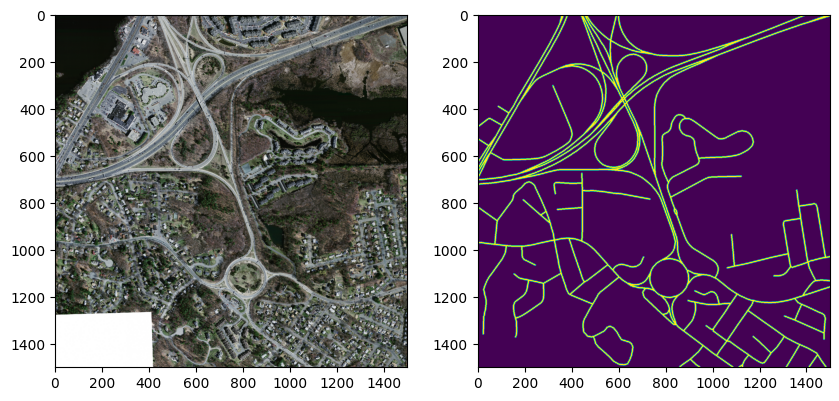

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[1].imshow(mask)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

### Augmentation

In [10]:
import albumentations as A

In [11]:
def get_train_args():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ])

def get_valid_args():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

### Create Custom Dataset

In [12]:
from torch.utils.data import Dataset


In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]

    image_path = DATA_DIR + '/' + row.images
    mask_path = DATA_DIR + '/' + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h,w)
    mask = np.expand_dims(mask, axis= -1) # (h,w,c)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image'] #(h,w,c)
      mask = data['mask'] #(h, w, c)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask



In [14]:
trainset = SegmentationDataset(train_df, get_train_args())
validset = SegmentationDataset(valid_df, get_valid_args())

In [15]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


### Visualization

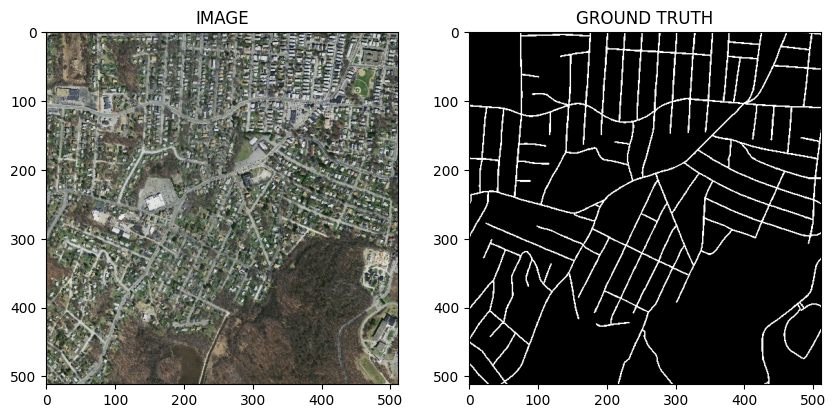

In [16]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

### Load Dataset into Data Loader

In [17]:
from torch.utils.data import DataLoader

In [18]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
print(f'Total no. of batches in trainloader: {len(train_loader)}')
print(f'Total no. of batches in validloader: {len(valid_loader)}')

Total no. of batches in trainloader: 20
Total no. of batches in validloader: 5


In [20]:
for images, masks in train_loader:
  print(f'One batch of images shape: {images.shape}')
  print(f'One batch of masks shape: {masks.shape}')
  break;

One batch of images shape: torch.Size([8, 3, 512, 512])
One batch of masks shape: torch.Size([8, 1, 512, 512])


### Create Segmentation Model

In [21]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)
    loss = 0

    if masks != None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits



In [23]:
model = SegmentationModel()
model = model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 13.6MB/s]


In [24]:
def train_fn(dataloader, model, optimizer):
  model.train()

  total_loss = 0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [25]:
def eval_fn(dataloader, model):
  model.eval()

  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(dataloader)

### Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [27]:
best_loss = np.Inf

for i in range(EPOCHS):
  print(f'Epoch {i+1}')

  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f'Epoch: {i +1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')

Epoch 1


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED-MODEL
Epoch: 1, Train Loss: 1.2804895222187043, Valid Loss: 1.116693925857544
Epoch 2


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED-MODEL
Epoch: 2, Train Loss: 0.9802635073661804, Valid Loss: 0.8956965684890748
Epoch 3


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVED-MODEL
Epoch: 3, Train Loss: 0.8291188091039657, Valid Loss: 0.7924388170242309
Epoch 4


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch: 4, Train Loss: 0.7458485931158065, Valid Loss: 0.7543594837188721
Epoch 5


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED-MODEL
Epoch: 5, Train Loss: 0.7089608937501908, Valid Loss: 0.7089740037918091
Epoch 6


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


SAVED-MODEL
Epoch: 6, Train Loss: 0.6794227063655853, Valid Loss: 0.6393497347831726
Epoch 7


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch: 7, Train Loss: 0.6769347161054611, Valid Loss: 0.641809594631195
Epoch 8


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


SAVED-MODEL
Epoch: 8, Train Loss: 0.6571126401424408, Valid Loss: 0.6326995968818665
Epoch 9


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 9, Train Loss: 0.6477504014968872, Valid Loss: 0.6688155889511108
Epoch 10


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


SAVED-MODEL
Epoch: 10, Train Loss: 0.6323163092136384, Valid Loss: 0.6199465036392212
Epoch 11


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVED-MODEL
Epoch: 11, Train Loss: 0.6288757920265198, Valid Loss: 0.5883329033851623
Epoch 12


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch: 12, Train Loss: 0.6185788631439209, Valid Loss: 0.6145732939243317
Epoch 13


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 13, Train Loss: 0.6121253073215485, Valid Loss: 0.622507631778717
Epoch 14


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch: 14, Train Loss: 0.6077147096395492, Valid Loss: 0.6437789797782898
Epoch 15


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


SAVED-MODEL
Epoch: 15, Train Loss: 0.6104747414588928, Valid Loss: 0.5727413535118103
Epoch 16


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 16, Train Loss: 0.6044524610042572, Valid Loss: 0.5980085372924805
Epoch 17


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 17, Train Loss: 0.6005379229784011, Valid Loss: 0.575254499912262
Epoch 18


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED-MODEL
Epoch: 18, Train Loss: 0.5865057855844498, Valid Loss: 0.563119524717331
Epoch 19


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED-MODEL
Epoch: 19, Train Loss: 0.5738241702318192, Valid Loss: 0.54834343791008
Epoch 20


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 20, Train Loss: 0.5805882573127746, Valid Loss: 0.5712298572063446
Epoch 21


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch: 21, Train Loss: 0.5795596927404404, Valid Loss: 0.576641970872879
Epoch 22


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 22, Train Loss: 0.5814609095454216, Valid Loss: 0.570284515619278
Epoch 23


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 23, Train Loss: 0.5772532597184181, Valid Loss: 0.5624787509441376
Epoch 24


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 24, Train Loss: 0.5722090259194375, Valid Loss: 0.5507783114910125
Epoch 25


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

Epoch: 25, Train Loss: 0.5678160905838012, Valid Loss: 0.5927117764949799


### Inference

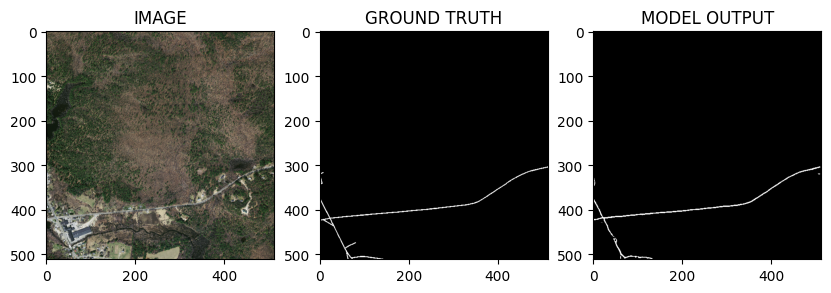

In [30]:
idx = 30
model.load_state_dict(torch.load('best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.unsqueeze(0).to(DEVICE)) #(c, h, w) -> (b, c, h, w)
mask_pred = torch.sigmoid(logits_mask) #(b, c, h, w)
mask_pred = (mask_pred > 0.5) * 1.0

helper.show_image(image, mask, mask_pred.detach().cpu().squeeze(0))